# Übung 9

Gruppenname: TSRI
<ul>
    <li>Christian Rene Thelen @cortex359
    <li>Leonard Schiel @leo_paticumbum</li>
    <li>Marine Raimbault @Marine Raimbault</li>
    <li>Alexander Ivanets @sandrium</li>
</ul>

Gehen Sie wie folgt vor:

1. Bitte benennen Sie jetzt dieses Jupyter Notebook um (z.B. über `File -> Rename`):

   Namensschema: `Gruppenname-X`. Ersetzen Sie "X" mit der oben angegebenen Nummer der Übung.

   - Beispiel 1: Team REZA bearbeitet Übung 2. Das Notebook heißt: REZA-2.
   - Beispiel 2: Sie sind keinem Team zugeordnet (nicht empfehlenswert) und bearbeiten Übung 2: Ihr Notebook heißt: Nachname-2.


2. Tragen Sie Ihren Gruppennamen auch ganz oben bei "Name Ihrer Gruppe" ein.

3. Bearbeiten Sie dann dieses Notebook. Vergessen Sie dabei nicht, das Jupyter Notebook regelmäßig zu speichern (z.B. über `Strg + S` oder über `File -> Save and Checkpoint`).

### In dieser Übung ...

... werden Sie vertraut mit Clustervalidierungstechniken. Diese sind nützlich, um Parameter (wie beispielsweise die Anzahl der Cluster) einzustellen und die Qualität eines Clusterings zu bewerten.

### 9.1 Prediction Strength (Bestimmung der Clusteranzahl für K-Means)

Sie haben in der Vorlesung verschiedene Clustervalidierungsverfahren kennengelernt. Die *Prediction Strength* ist eine empfehlenswerte Validierungsmethode, die Sie im Rahmen dieser Übung implementieren und damit Ihr Verständnis vertiefen werden.

Hinweise

- Nutzen Sie die Implementierung des K-Means Algorithmus von Scikit-Learn.
- Für die Implementierung der *Prediction Strength* können Sie numpy, sklearn und scipy verwenden.

**Ihre Aufgaben**

(1) Schlagen Sie in den Vorlesungsfolien nach, wie die Prediction Strength definiert ist.

(2) Ich habe Ihnen synthetische Daten zur Übung bereitgestellt. Bitte führen Sie die unten stehende Code-Zelle aus. Sie erzeugt 150 Datenpunkte mit je zwei Features (Merkmalen, Array **X**), organisiert in 5 Clustern. Die "wahren" Clusterzugehörigkeiten sind im Vektor **y** kodiert.

- In der Praxis haben Sie selbstverständlich keine wahren Clusterzugehörigkeiten vorliegen. Sie wollen vielmehr im Rahmen Ihrer Clusteranalyse diese Clusterzugehörigkeiten erkennen. In dieser Übung nutzen wir **y** lediglich für die Visualisierung, die die folgende Codezelle erzeugt, und löschen danach diese Variable wieder.

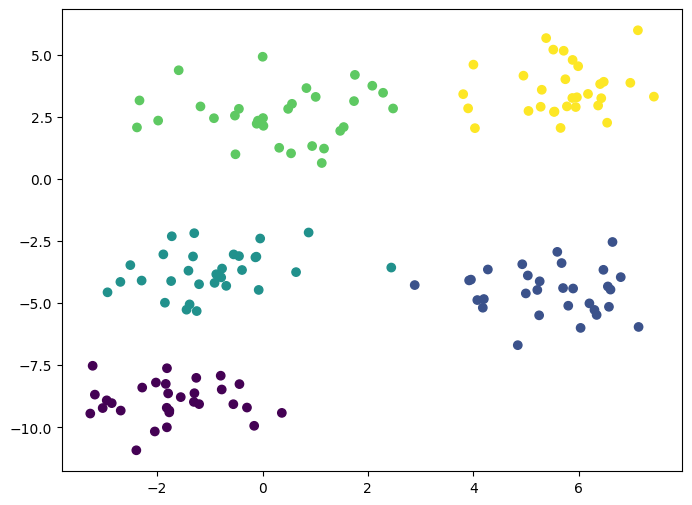

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt, rcParams
rcParams['figure.figsize'] = (8, 6)

# generate data
X, y = make_blobs(n_samples=150, centers=5, cluster_std=1, random_state=40)

# visualize data
plt.scatter(x=X[:, 0], y=X[:, 1], c=y)

del y

(3) [Teilen Sie](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) die Daten **zufällig** in ein Trainings- und ein Validierungsset auf. Das Validierungsset soll dabei 20% der Gesamtdatenpunkte enthalten, das Trainingsset 80%.

- Ihre Datenvariablen heißen `X_train` und `X_valid`. (Scikit-Learn bezeichnet unser Validierungsset als Testset; lassen Sie sich dadurch nicht verwirren.)

- Nutzen Sie `random_state=40`, damit Sie Ihre Ergebnisse einfach mit denen Ihrer Kolleginnen und Kollegen vergleichen können.

In [4]:
from sklearn import model_selection
X_train, X_valid = model_selection.train_test_split(X, test_size=0.2, random_state=40)

(4) Für die nachfolgenden (Debugging-)Schritte ist es hilfreich, wenn Sie bereits jetzt mittels K-Means jeweils Cluster im Trainings- und Validierungsset bestimmen.

- Nutzen Sie bei den nachfolgenden Schritten jeweils `random_state=42`, um vergleichbare Ergebnisse wie Ihre Kolleginnen und Kollegen zu erhalten.

1. Ermitteln Sie mittels [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) $K=8$ Cluster im **Trainingsset** (setzen Sie den Parameter `n_init=10`, um die Warning zu deaktivieren). Speichern Sie die *Centroids* (auch *cluster_centers* genannt) der Cluster in der Variablen `train_centroids`.
2. Ermitteln Sie mittels eines **neuen** K-Means Modells ebenfalls $K=8$ Cluster im **Validierungsset** (setzen Sie den Parameter `n_init=10`, um die Warning zu deaktivieren). Speichern Sie die Clusterzugehörigkeiten (*cluster labels*) der Daten im Validierungsset in der Variablen `valid_labels`.

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
train_centroids = kmeans.fit(X_train).cluster_centers_
print(f'Train centroid: {train_centroids}')

valid_labels = kmeans.fit_predict(X_valid)
print(f'Valid labels: {valid_labels}')

Train centroid: [[ 3.78601248 -3.98739961]
 [-1.07586647 -3.74803654]
 [ 5.44934314  2.91839652]
 [-1.57465743 -8.94228327]
 [-0.24227718  2.09145075]
 [ 6.04656076 -4.7045427 ]
 [ 1.20350451  3.32397371]
 [ 6.04902816  4.60553525]]
Valid labels: [6 0 7 4 5 3 4 7 6 3 4 1 5 4 3 5 1 2 0 7 3 6 5 0 6 4 2 2 4 3]


(5) Sie werden die Prediction Strength in mehreren Schritten implementieren. Implementieren Sie zunächst eine Funktion `get_comembership_matrix`, die die Co-Membership Matrix $M$ (Ko-Mitgliedschaftsmatrix) aus den Daten bestimmt.

**Hintergrund**

Die Matrix $M$ kodiert, welches Paar von Datenpunkten aus dem Validierungsset demselben Cluster im Trainingsset zugeordnet ist. *Damit enthält die Implementierung der Funktion `get_comembership_matrix` implizit unsere Annahmen darüber, wie ein Clustergebiet im Merkmalsraum aussehen sollte.* Verschiedene Clusterverfahren treffen unterschiedliche Annahmen. Daher unterscheidet sich die Implementierung von `get_comembership_matrix` je nach gewähltem Clusteringverfahren!

Wir wollen später Clusterings validieren, die wir mittels K-Means erzeugt haben. Bei K-Means werden Datenpunkte dem Cluster zugeordnet, dessen *Centroid* (Clusterzentrum) sie am nächsten liegen. Um zu bestimmen, ob zwei Datenpunkte aus dem Validierungsset demselben Cluster des Trainingssets angehören, müssen Sie also prüfen, ob Sie demselben Centroid aus dem Trainingsset am nächsten liegen.

**Hinweise**

- Die Funktion `get_comembership_matrix` nimmt die Daten `X_valid` sowie die `train_centroids` entgegen und gibt die Co-Membership Matrix `M` zurück.

- Bei der Implementierung können Ihnen Funktionen hilfreich sein, die Sie unterstützen bei (i) der Bestimmung [euklidischer Distanzen](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html), (ii) bei der Bestimmung des [Arrayindexes mit dem kleinsten Eintrag](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html) sowie (iii) der [Bestimmung aller Indizes von Arrayeinträgen](https://numpy.org/doc/stable/reference/generated/numpy.argwhere.html), die eine Bedingung erfüllen.


In [58]:
from scipy.spatial.distance import cdist
def get_comembership_matrix(X_valid, train_centroids):
    dists = cdist(X_valid, train_centroids, 'euclidean') # 30 Rows, 8 Columns
    min_dists = np.argmin(dists, axis=1)
    M = np.zeros((X_valid.shape[0], X_valid.shape[0])) 
    for i in range(len(min_dists)):
        for j in range(len(min_dists)):
            if min_dists[i] == min_dists[j]:
                M[i, j] += 1
    return M

M = get_comembership_matrix(X_valid, train_centroids)
print(M)

[[1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.
  1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.
  1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.
  1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 

(6) Implementieren Sie nun die Funktion `get_prediction_strength`, die eine Co-Membership Matrix `M`, die Clusterzugehörigkeiten auf dem Validierungsset `valid_labels` sowie die Anzahl $K$ von Clustern entgegennimmt und die *Prediction Strength* `ps` zurückliefert.

- Rufen Sie sich dazu noch einmal mithilfe der Vorlesungsfolien in Erinnerung, wie die Prediction Strength definiert ist.
- Bei der Implementierung kann Ihnen [dies hier](https://numpy.org/doc/stable/reference/generated/numpy.argwhere.html) hilfreich sein.

In [55]:
def get_prediction_strength(M, valid_labels, K):
    matrix_sum = np.sum(M) - np.diag(M).sum() # Sum of all elements from M
    _, idx, c = np.unique(valid_labels, return_inverse=True, return_counts=True) 
    ps = np.array([1 / (x * (x - 1)) * matrix_sum for x in c])
    return ps.min()
    
get_prediction_strength(M, valid_labels, 8)

[3 2 3 5 6 4 4 3]


3.466666666666667

(7) Visualisieren Sie die *Prediction Strength* als Funktion der Clusteranzahl $K$ für $K\in\{1, \ldots 9\}$.

Hierzu müssen Sie für jeden Wert $K$ ein Clustering auf den Trainingsdaten und auf den Validierungsdaten durchführen, die Co-Membership-Matrix $M$ und anschließend die Prediction Strength bestimmen. Beschriften Sie die y-Achse mit "Prediction Strength" und die x-Achse mit "Clusteranzahl".

(8) Lesen Sie die optimale Anzahl an Clustern anhand Ihrer Visualisierung aus Schritt (7) ab und geben Sie sie hier an. Die optimale Clusteranzahl ist die größte Zahl $K>1$, für die die Prediction Strength noch den größten Wert annimmt.

- Stimmt die von Ihnen ermittelte Clusteranzahl mit der "wahren" Anzahl der Cluster (vgl. Schritt (1)) in den Daten überein?

(9) \[Optional\] In der Praxis wird oft die Prediction Strength im Rahmen einer sogenannten Kreuzvalidierung ermittelt. Dabei werden alle Daten `X` in $V$ disjunkte Mengen (sogenannte *Folds*) aufgespalten, wobei die Daten aus $(V-1)$ Folds als Trainingsset und dem verbliebenen Fold als Validierungsset angesehen wird. Durch Durchtauschen der Zuordnungen der Folds zu Trainings- und Validierungsset lassen sich so $V$ mal die Prediction Strength bestimmen (jedes Fold dient einmal als Validierungsdatensatz). Die $V$ Werte für die Prediction Strength werden anschließend arithmetisch gemittelt.

- Bestimmen Sie für $K\in\{1, \ldots, 9\}$ mittels 5-facher Kreuzvalidierung die Prediction Strength und visualisieren Sie sie. Dabei kann Ihnen ggf. [diese Funktion](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) hilfreich sein.
